# Fruit Classification using transfer learning

**Author:** Peyman Kh

**Date:** 2025-03-28  

**Task:** to classify images of different fruits using a CNN

**Dataset:** https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip  


# 1. Imports & Setup

In [37]:
# Import necessary libraries
import os
import random
import zipfile
import subprocess
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D

In [2]:
# Set random seed
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print(f"Random seeds set to {seed}.")

set_seed(42)

Random seeds set to 42.


# 2. Data loading & Preprocessing

In [7]:
# Define dataset URL and paths
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip"
local_zip = "fruits-360-original-size.zip"
extract_dir = "fruits-360-original-size"

def download_dataset(url, output_file):
    """Download the dataset using wget in quiet mode."""
    print("Downloading the dataset...")
    subprocess.run(["wget", "-q", "-O", output_file, url], check=True)  # Add `-q` for quiet mode
    print("Download completed.")

def extract_zip_in_chunks(zip_file, extract_to, batch_size=2000):
    """
    Extract a large zip file in chunks to avoid memory bottlenecks.
    Processes a specified number of files (batch_size) at a time.
    """
    print("Extracting the dataset in chunks...")
    os.makedirs(extract_to, exist_ok=True)  # Ensure the extraction directory exists

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        files = zip_ref.namelist()  # List all files in the archive
        total_files = len(files)

        for i in range(0, total_files, batch_size):
            batch = files[i:i+batch_size]
            for file in batch:
                zip_ref.extract(file, extract_to)  # Extract each file in the batch
            print(f"Extracted {min(i+batch_size, total_files)} of {total_files} files...")

    print(f"Dataset successfully extracted to '{extract_to}'.")

# Main script execution
if __name__ == "__main__":
    # Download the dataset if not already downloaded
    if not os.path.exists(local_zip):
        download_dataset(url, local_zip)
    else:
        print("Dataset already downloaded.")

    # Extract the dataset if not already extracted
    if not os.path.exists(extract_dir):
        extract_zip_in_chunks(local_zip, extract_dir)
    else:
        print("Dataset already extracted.")

    # Optional cleanup of the zip file
    if os.path.exists(local_zip):
        os.remove(local_zip)
        print(f"Cleaned up zip file: {local_zip}")


Download completed.
Extracting the dataset in chunks...
Extracted 2000 of 12481 files...
Extracted 4000 of 12481 files...
Extracted 6000 of 12481 files...
Extracted 8000 of 12481 files...
Extracted 10000 of 12481 files...
Extracted 12000 of 12481 files...
Extracted 12481 of 12481 files...
Dataset successfully extracted to 'fruits-360-original-size'.
Cleaned up zip file: fruits-360-original-size.zip


In [9]:
# Set dataset paths
train_dir = 'fruits-360-original-size/fruits-360-original-size/Training'
val_dir = 'fruits-360-original-size/fruits-360-original-size/Validation'
test_dir = 'fruits-360-original-size/fruits-360-original-size/Test'

Number of classes: 24

Total training images: 6231

Sample class distribution (first 5 classes):
apple_6: 315 images
apple_braeburn_1: 320 images
apple_crimson_snow_1: 318 images
apple_golden_1: 308 images
apple_golden_2: 308 images


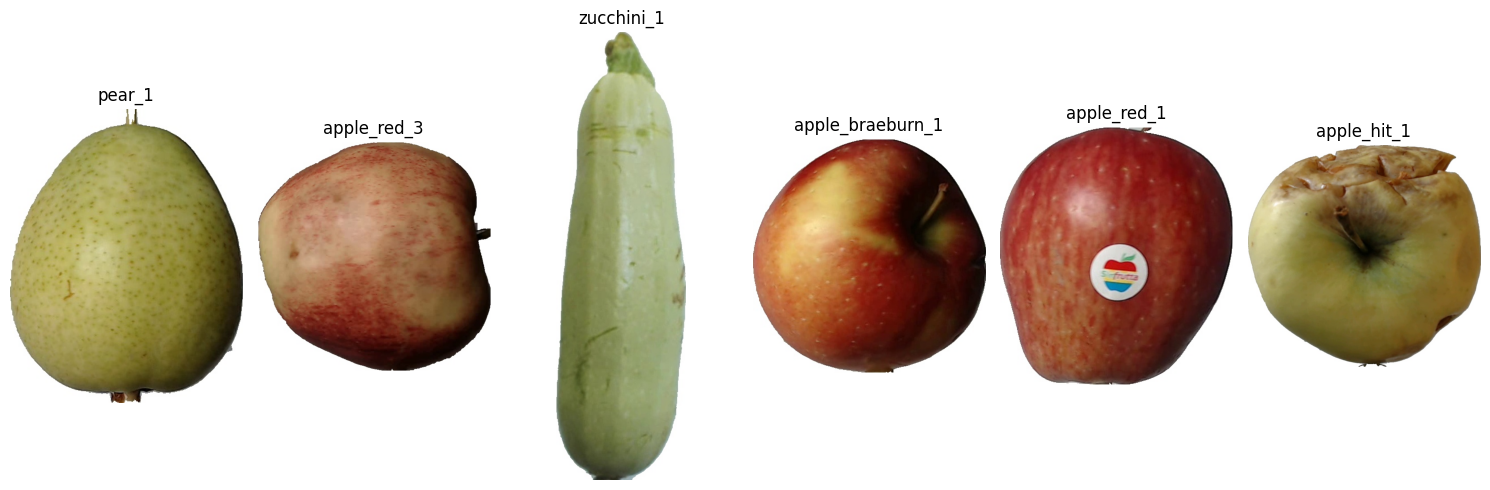


Sample image path: fruits-360-original-size/fruits-360-original-size/Training/apple_golden_1/r0_178.jpg
Image shape: (322, 358, 3) (Height, Width, Channels)


In [21]:
# Inspecting the dataset to understand it better
def count_classes_and_images(base_dir):
    """Count number of classes and images in a given directory."""
    class_names = sorted(os.listdir(base_dir))
    class_counts = {}
    total_images = 0

    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
            total_images += num_images

    return class_names, class_counts, total_images

def show_random_images(base_dir, class_names, num_images=6):
    """Display a few random images from the dataset."""
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        class_name = random.choice(class_names)
        class_path = os.path.join(base_dir, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)

        img = image.load_img(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Inspect the training set
train_classes, train_counts, train_total = count_classes_and_images(train_dir)
print(f"Number of classes: {len(train_classes)}\n")
print(f"Total training images: {train_total}\n")
print("Sample class distribution (first 5 classes):")
for cls in train_classes[:5]:
    print(f"{cls}: {train_counts[cls]} images")

# Show random training images
show_random_images(train_dir, train_classes)

# Pick a random image from the training set
sample_class = random.choice(train_classes)
sample_image_path = os.path.join(train_dir, sample_class, random.choice(os.listdir(os.path.join(train_dir, sample_class))))
img = image.load_img(sample_image_path)
img_array = image.img_to_array(img)

print(f"\nSample image path: {sample_image_path}")
print(f"Image shape: {img_array.shape} (Height, Width, Channels)")


In [22]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values from [0, 255] to [0, 1]
    rotation_range=20,  # Random rotation (±20 degrees)
    width_shift_range=0.1,  # Horizontal shift by up to 10% of width
    height_shift_range=0.2,  # Vertical shift by up to 20% of height
    shear_range=0.2,  # Shearing transformation
    zoom_range=0.2,  # Zoom in/out by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in pixels after a transform (e.g., rotate)
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'  # For multi-class classification (softmax)
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)


Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


# 3. Model Definition

In [29]:
# Load VGG16 with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Freez the base model layer
for layer in base_model.layers:
  layer.trainable = False

In [34]:
# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(name='global_avg_pool'),  # Reduces spatial dimensions
    Dense(256, activation='relu', name='dense_256_relu'),
    BatchNormalization(name='batch_norm'),  # stabilizes training
    Dropout(0.3, name='dropout_30'),  # Helps prevent overfitting
    Dense(train_generator.num_classes, activation='softmax', name='output_softmax')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool                      │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256_relu (Dense)               │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm (BatchNormalization)      │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_softmax (Dense)               │ (None, 24)                  │           6,168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,853,208 (56.66 MB)

 Trainable params: 138,008 (539.09 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

# 4. Compile & Train

In [41]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
# Train the model with early stopping and learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Enable mixed precision (if on GPU)
set_global_policy('float32')

steps_per_epoch = 50
validation_steps = 25

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.1711 - loss: 3.1165 - val_accuracy: 0.2550 - val_loss: 2.5988 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4579 - loss: 1.7641 - val_accuracy: 0.3400 - val_loss: 2.3323 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5994 - loss: 1.2697 - val_accuracy: 0.5625 - val_loss: 1.6793 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7040 - loss: 1.0013 - val_accuracy: 0.6000 - val_loss: 1.3888 - learning_rate: 0.0010
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6826 - loss: 1.0328 - val_accuracy: 0.6525 - val_loss: 1.2155 - learning_rate: 0.0010


# 5. Fine-tune the model

In [43]:
# Check the number of layers in the base model
num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")

The base model has 19 layers.


In [45]:
# Unfreeze the last 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Freeze BatchNorm layers to speed up fine-tuning
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

In [46]:
# Re-compile the model with a faster optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),   # Higher learning rate for faster convergence
    metrics=['accuracy']
)

# Continue training with fewer steps per epoch
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,  # Reduced steps per epoch
    validation_steps=validation_steps,  # Reduced validation steps
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7400 - loss: 0.8420 - val_accuracy: 0.7175 - val_loss: 0.9121 - learning_rate: 1.0000e-05
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7401 - loss: 0.7371 - val_accuracy: 0.7925 - val_loss: 0.6289 - learning_rate: 1.0000e-05
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8225 - loss: 0.6362 - val_accuracy: 0.8050 - val_loss: 0.5731 - learning_rate: 1.0000e-05
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8170 - loss: 0.5762 - val_accuracy: 0.8575 - val_loss: 0.4505 - learning_rate: 1.0000e-05
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8170 - loss: 0.6176 - val_accuracy: 0.8425 - val_loss: 0.4979 - learning_rate: 1.0000e-05


# 6. Model evaluation

In [47]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f"Test Accuracy: {test_accuracy:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 814ms/step - accuracy: 0.8250 - loss: 0.5023
Test Accuracy: 0.84


# 7. Visualizing performance

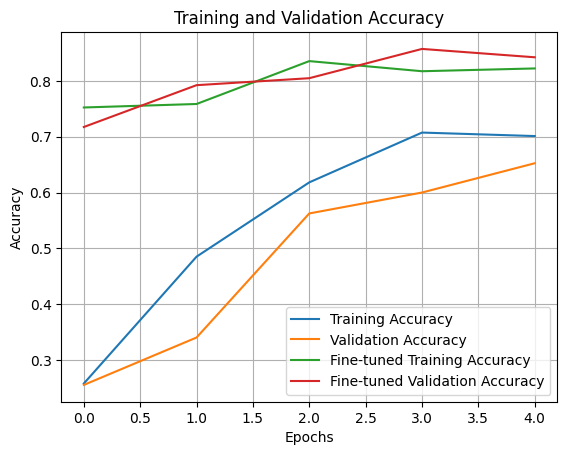

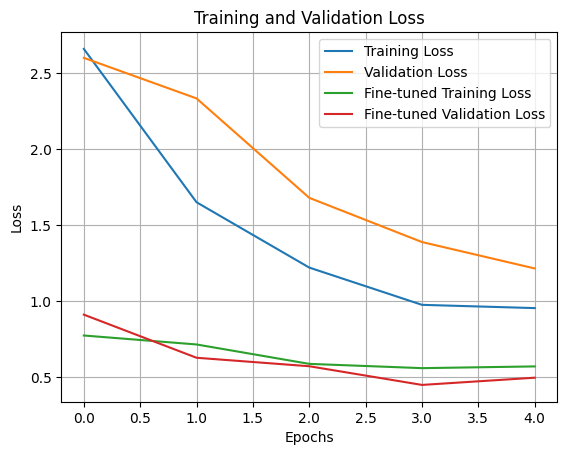

In [48]:
# Plot accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

Class Index Mapping: {'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


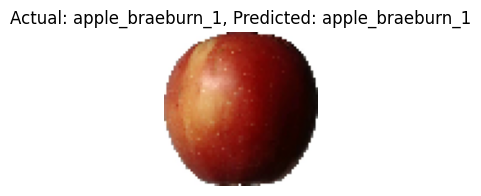

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


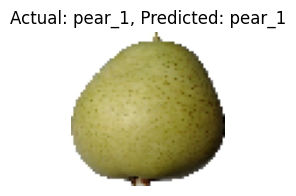

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


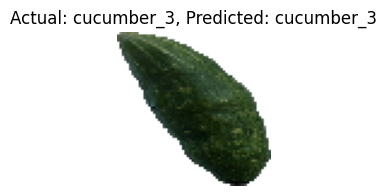

In [49]:
import os
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Initialize counters for actual and predicted classes
actual_count = Counter()
predicted_count = Counter()

# Function to get class name from predicted index
def get_class_name_from_index(predicted_index, class_index_mapping):
    """Convert predicted index to class name."""
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Unknown"  # Default if index is not found

# Define the function for visualization
def visualize_prediction_with_actual(img_path, class_index_mapping):
    # Extract the true label dynamically from the directory structure
    class_name = os.path.basename(os.path.dirname(img_path))  # Extract folder name (class)

    # Load and preprocess the image
    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

    # Update the counters
    actual_count[class_name] += 1
    predicted_count[predicted_class_name] += 1

    # Visualize the image with predictions
    plt.figure(figsize=(2, 2), dpi=100)
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

# Retrieve class index mapping from the training generator
class_index_mapping = train_generator.class_indices
print("Class Index Mapping:", class_index_mapping)  # Debugging: Check the mapping

# Define a list of image paths without hardcoded labels
sample_images = [
    'fruits-360-original-size/fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/pear_1/r0_103.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/cucumber_3/r0_103.jpg',
]

# Run the predictions and visualization
for img_path in sample_images:
    visualize_prediction_with_actual(img_path, class_index_mapping)
